# Neural & Behavioral Modeling - Week 14 (Exercises)
by 駱皓正 (austenpsy@gmail.com)

In [ ]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [10]:
# Check GPU status:
# import torch as t
from torch import *
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
No GPU


## 1 Activation/Signal Function in RNN (10 points)

tanh(x) is a more popular choice of activation function than sigmoid(x) & relu(x) in contemporary RNNs.
Below please use simple RNN to compare 3 activation functions in terms of their learning efficiency and capacity. If there is any significant difference, please discuss why. 

nn.RNN(..., nonlinearity='relu') allows you to switch tanh to relu. However, you need some deep hacking of the source code to replace nn.Tanh with nn.Sigmoid. Alternatively, you can <a href="https://www.cpuheater.com/deep-learning/introduction-to-recurrent-neural-networks-in-pytorch/">code a simple RNN from scratch</a> to have a better control of everything!

### 1.0 Data: sin(t) → cos(t)

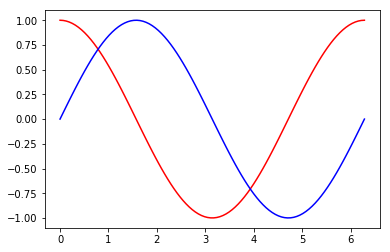

In [14]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)
plot(steps, y_np, 'r-', label='y (cos)')
plot(steps, x_np, 'b-', label='x (sin)')
#plt.legend(loc='best');

### 1.1 RNN model for 1D-to-1D time-series regression (7 points)

In [98]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.modules.rnn as mornn

torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step / image height
INPUT_SIZE = 1      # rnn input size / image width
LR = 0.001           # learning rate
DOWNLOAD_MNIST = False  # set to True if haven't download the data


### Tanh Version

In [94]:
#normal linear version

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(  # 这回一个普通的 RNN 就能胜任
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入

        outs = []    # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

rnn = RNN()

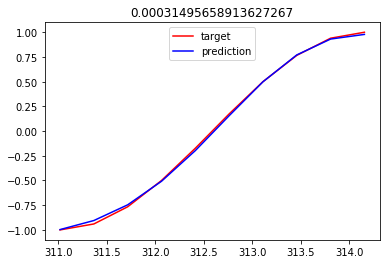

In [95]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state

for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sine to predict cosine
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    h_state = h_state.data                  # get rid of the autograd part and retain the data part only
 
    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    clf() # clear previous figure
    plot(steps, y_np.flatten(), 'r-', label='target')
    plot(steps, prediction.data.numpy().flatten(), 'b-', label='prediction')
    title(loss.item()); legend(loc=9)
    display(gcf()); clear_output(wait=True) # to allow dynamic plots

### ReLU version

In [109]:
#normal linear version

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(  # 这回一个普通的 RNN 就能胜任
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
            nonlinearity='relu'
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入

        outs = []    # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

rnn = RNN()

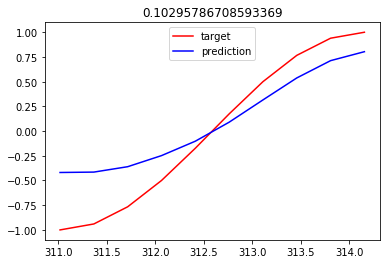

In [110]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state

for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sine to predict cosine
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    h_state = h_state.data                  # get rid of the autograd part and retain the data part only
 
    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    clf() # clear previous figure
    plot(steps, y_np.flatten(), 'r-', label='target')
    plot(steps, prediction.data.numpy().flatten(), 'b-', label='prediction')
    title(loss.item()); legend(loc=9)
    display(gcf()); clear_output(wait=True) # to allow dynamic plots

### 1.2 Conclusions (3 points)

The significant problem of RNN is the gradient vanishing problem, to some extand, tanh(x) can somewhat solve this problem indirectively.

tanh(z) = [exp(z) - exp(-z)] / [exp(z) + exp(-z)]

tanh'(z) = 1 - ([exp(z) - exp(-z)] / [exp(z) + exp(-z)])^2 = 1 - tanh^2(z)

From the first derivative of tanh(x), we can found that this func would be convergent sooner. this is only one possible explanation. But the discuss of merits and demerits of tanh and relu not reach a consensus. Maybe it depends.

In the case above, we can find that tanh performs better than relu, may be the tanh learns faster or tanh locates in [-1,1] not [0,1].

sigmoid func cannot be implemented only through pytorch.nn.Module.rnn, correction would involve nn.backend and cudnn and subprocess.